<a href="https://colab.research.google.com/github/ls2092/CV/blob/main/DMML_GROUP_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **READ THIS**
*IMPORTANT*

*   After training / doing any changes to the data, make sure to save those changes in the google drive file. *(THIS IS VERY IMPORTANT AS AFTER YOU TUN OFF THE VM, ALL OUR DATA OF THE TRAINED MODEL WILL NOT SAVE, SO UNLESS YOU SAVE IT THERE IS NO POINT)*

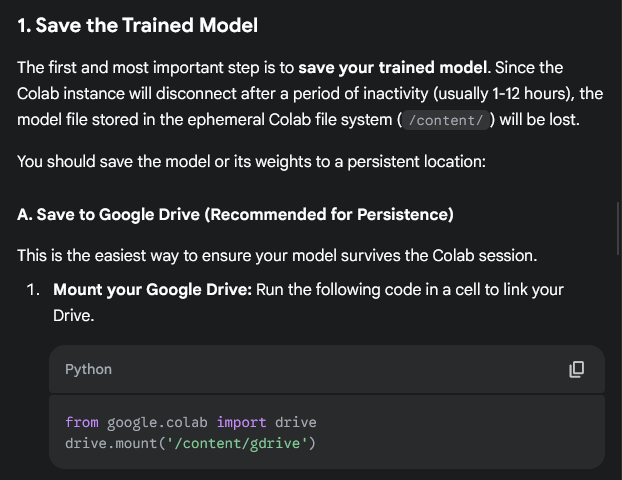

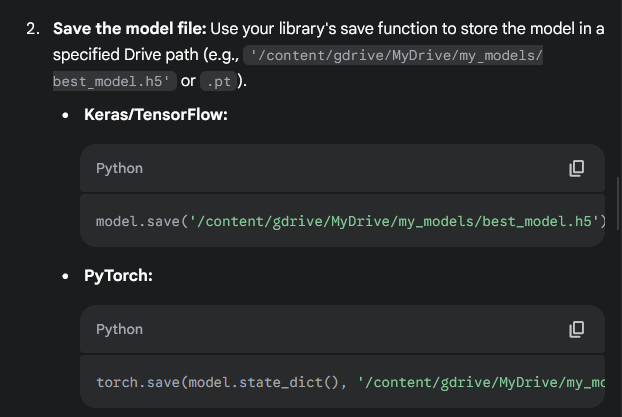

*   After finishing your work , make sure you do **CTRL + S** to save the document and then also commit the changes on the github by going to **File-> Save a copy in GITHUB**, log into your github and select our repo and then make sure the name of the **ipynb** file already matches what is already there in the repo **(DMML_GROUP_12.ipynb)** and put a commit message and save it there.

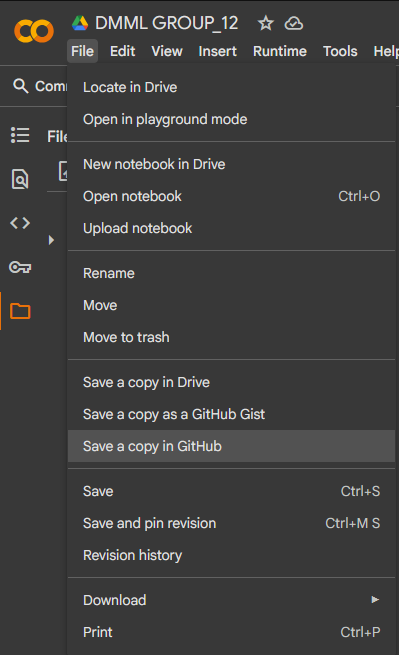



* A**BOVE EACH LAB, ADD YOUR DEPENDANCIES AND INSTALL THEM IF REQUIRED AS EACH TIME THE VM STOPS, THOSE DEPENDANCIES COULD GET DELETED AS WELL. (EG - pip install numpy, mathplotlib, etc) (IF REQUIRED)**

# **RUN THIS TO CONNECT TO THE DRIVE**


*   THIS HAS TO BE RUN TO CONNECT TO THE DRIVE EVERYTIME YOU START THE VM




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Pre processing features in Ad_table - VIR**

Modified the Ad_table to remove the Ad_month and saved it as a new table called Adv_table. Decided to not use Basic_table, Sales_table, Trim_table for the training, as it is not required for our aim.

In [ ]:
import pandas as pd

file_path = '/content/drive/MyDrive/DMML DATA/tables_V2.0/Ad_table.csv'

df = pd.read_csv(file_path, low_memory=False)
df.head()

df = df.drop(['Adv_month'], axis=1)

df.to_csv('/content/drive/MyDrive/DMML DATA/tables_V2.0/Adv_table.csv', index=False)


# **XGBOOST - Laiba**
Applying XGBoost on tabular data of adv_table and price_table to predict the resale price of given car

Data Loaded
Price Table size: (6333, 5)
Ad Table size: (268255, 15)

--- Merged Data Shape: (268255, 16) ---
Number of unique Makers: 88


--- Train/Test Split ---
Total samples: 255898
Training samples: 204693 (80.0%)
Testing samples: 51205 (20.0%)

Training XGBoost Regressor for Resale Price
Training complete.

Model Evaluation (Resale Price)
R-squared (Accuracy): 0.9422
Mean Absolute Error (MAE): 2,583.35
Root Mean Squared Error (RMSE): 4,792.05

--- Actual vs. Predicted Resale Prices (Sample of Test Set) ---
| Maker   | Genmodel   | Year   | Actual_Resale_Price   | Predicted_Resale_Price   |
|:--------|:-----------|:-------|:----------------------|:-------------------------|
| Abarth  | 595        | 2018   | 13000                 | 13145.8                  |
| Abarth  | 595C       | 2019   | 26075                 | 20144.3                  |
| Abarth  | 595        | 2014   | 10990                 | 8254.4                   |
| Abarth  | 595        | 2016   | 11500                 |

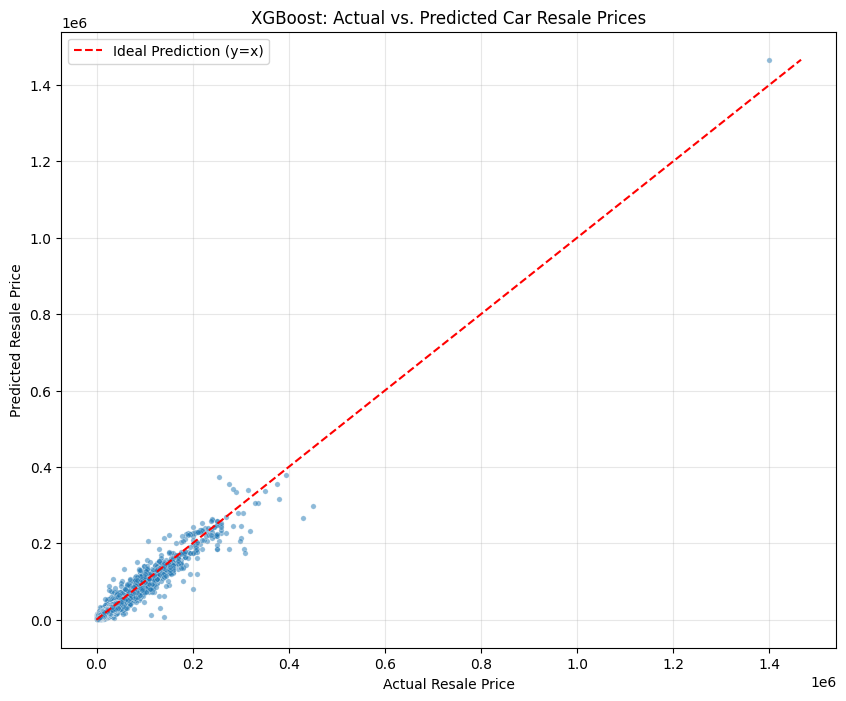

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# the two tables used to train the model are price table and advertisement table
# file paths for both tables
price_table = "/content/drive/MyDrive/DMML DATA/tables_V2.0/Price_table.csv"
adv_table = "/content/drive/MyDrive/DMML DATA/tables_V2.0/Adv_table.csv"

# reading both tables
price_data = pd.read_csv(price_table, low_memory=False)
adv_data = pd.read_csv(adv_table, low_memory=False)

#removing extra whitespaces from every string of each column (because of KeyError)
price_data.columns = price_data.columns.str.strip()
adv_data.columns = adv_data.columns.str.strip()

print("Data Loaded")

#checking if data got loaded
print(f"Price Table size: {price_data.shape}")
print(f"Ad Table size: {adv_data.shape}")

#data cleaning and preprocessing
#target Variable is resale price which is 'Price' from Adv_Table
TARGET_COLUMN = 'Price'

#Clean Engin_size in Adv_table to remove non-numeric labels like L(litre)
def clean_engine_size(size_str):
   #converts engine size string (e.g., '2.0L') to float (2.0)
    if pd.isna(size_str):
        return None
    try:
        #remove 'L'
        return float(str(size_str).replace('L', '').strip())
    except ValueError:
        return None


adv_data['Engine_size_L'] = adv_data['Engin_size'].apply(clean_engine_size)
#drop original Engin_size column
adv_data = adv_data.drop(columns=['Engin_size'])

#Clean and convert Runned_Miles and Price to numeric (removing commas)
def clean_and_convert_numeric(series):
    #convert to string, replace common non-numeric characters (like commas), then coerce to numeric
    clean_series = series.astype(str).str.replace(r'[$,]', '', regex=True).str.strip()
    return pd.to_numeric(clean_series, errors='coerce')

adv_data['Runned_Miles'] = clean_and_convert_numeric(adv_data['Runned_Miles'])
#apply cleaning to Price
adv_data['Price'] = clean_and_convert_numeric(adv_data['Price'])


#Merge Data
#merge is done on Maker, Genmodel_ID, and Year to link advertisement features to the specific year's MSRP/Entry_price
merge_cols_adv = ['Maker', 'Genmodel_ID', 'Reg_year']
merge_cols_price = ['Maker', 'Genmodel_ID', 'Year']

#rename 'Reg_year' in adv_data to 'Year' for consistent merging
adv_data = adv_data.rename(columns={'Reg_year': 'Year'})

#merging the Price_table just to get the 'Entry_price' as a feature.
merged_df = pd.merge(
    adv_data,
    #pulling 'Entry_price' to use as a feature
    price_data[['Maker', 'Genmodel_ID', 'Year', 'Entry_price']],
    on=['Maker', 'Genmodel_ID', 'Year'],
    how='left'
)

print(f"\n--- Merged Data Shape: {merged_df.shape} ---")
print(f"Number of unique Makers: {merged_df['Maker'].nunique()}")

#handle missing values and feature selection
#dropping rows with nulls
merged_df = merged_df.dropna(subset=[
    'Runned_Miles', 'Engine_size_L', 'Seat_num', 'Door_num', TARGET_COLUMN
])

#features to be used for prediction
num_features = ['Runned_Miles', 'Engine_size_L', 'Seat_num', 'Door_num', 'Adv_year', 'Entry_price']
#filling null values in 'Entry_price' with the median
merged_df['Entry_price'] = merged_df['Entry_price'].fillna(merged_df['Entry_price'].median())

categorical_features = ['Maker', 'Genmodel', 'Color', 'Bodytype', 'Gearbox', 'Fuel_type']
total_features = num_features + categorical_features

X = merged_df[total_features]
y = merged_df[TARGET_COLUMN]

#converting categorical features into numerical format using One-Hot Encoding
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)

#Test Train Split (80-20 per Maker): if there are 80 cars of Maker 'Bentley' then 0.80*80 will be used for training and 0.20*80 will be used for testing purposes.
def custom_group_split(df, group_col, test_size=0.2):

    training_data = []
    testing_data = []

    #calculate the minimum number of samples needed for a split
    #if test_size is 0.2, min samples needed is 2 (1 in train, 1 in test)
    min_samples_required = 1 / (1 - test_size)
    if min_samples_required <= 1:
        min_samples_required = 2

    skipped_groups = 0

    for group_name, group in df.groupby(group_col):

        if len(group) < 2:
            #skip this group if it's too small to be split
            skipped_groups += 1
            training_data.extend(group.index)
            continue

        #use simple train_test_split on the indices of the group
        group_train_indices, group_test_indices = train_test_split(
            group.index,
            test_size=test_size,
            random_state=42
        )
        training_data.extend(group_train_indices)
        testing_data.extend(group_test_indices)

    if skipped_groups > 0:
        print(f"\nWarning: Skipped {skipped_groups} Maker groups (rows) that had fewer than 2 samples to split.")

    return df.loc[training_data].index, df.loc[testing_data].index

#get the indices for the split
train_index, test_index = custom_group_split(merged_df, 'Maker', test_size=0.2)

#craeting the final train and test sets using the indices
X_train = X_encoded.loc[train_index]
X_test = X_encoded.loc[test_index]
y_train = y.loc[train_index]
y_test = y.loc[test_index]

#checking split distribution for verification
print(f"\n--- Train/Test Split ---")
print(f"Total samples: {len(X_encoded)}")
print(f"Training samples: {len(X_train)} ({len(X_train)/len(X_encoded):.1%})")
print(f"Testing samples: {len(X_test)} ({len(X_test)/len(X_encoded):.1%})")

#training XGBoost Model
print("\nTraining XGBoost Regressor for Resale Price")

#initialize and train the XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

print("Training complete.")

#prediction and evaluation
y_pred = xgb_model.predict(X_test)

#evaluation metrics calculations
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\nModel Evaluation (Resale Price)")
print(f"R-squared (Accuracy): {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:,.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:,.2f}")

#Output Actual vs Predicted Prices
results_df = pd.DataFrame({
    'Actual_Resale_Price': y_test,
    'Predicted_Resale_Price': y_pred.round(2)
})

#add Maker and Genmodel back for context
context_df = merged_df.loc[test_index][['Maker', 'Genmodel', 'Year']]
results_df = context_df.merge(results_df, left_index=True, right_index=True)

print("\n--- Actual vs. Predicted Resale Prices (Sample of Test Set) ---")
print(results_df.head(10).to_markdown(index=False, numalign="left", stralign="left"))

#scatter plot showing predicted values against the line of actual values
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Actual_Resale_Price', y='Predicted_Resale_Price', data=results_df, alpha=0.5, s=15)
#find the maximum value for the limits
max_price = results_df[['Actual_Resale_Price', 'Predicted_Resale_Price']].max().max()
plt.plot([0, max_price], [0, max_price], color='red', linestyle='--', label='Ideal Prediction (y=x)')
plt.title('XGBoost: Actual vs. Predicted Car Resale Prices')
plt.xlabel('Actual Resale Price')
plt.ylabel('Predicted Resale Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# **Linear Regression - Nibras**
Applying Linear Regression on tabular data of adv_table and price_table to predict resale price of given car.


Price Table size: <bound method NDFrame.head of        Maker    Genmodel  Genmodel_ID   Year   Entry_price
0     Abarth  124 Spider          2_1   2016         29365
1     Abarth  124 Spider          2_1   2017         26665
2     Abarth  124 Spider          2_1   2018         26665
3     Abarth  124 Spider          2_1   2019         29515
4     Abarth         500          2_2   2009         13400
...      ...         ...          ...    ...           ...
6328   Volvo         V50         96_9   2008         15780
6329   Volvo         V50         96_9   2009         15770
6330   Volvo         V50         96_9   2010         17465
6331   Volvo         V50         96_9   2011         17615
6332   Volvo         V50         96_9   2012         19375

[6333 rows x 5 columns]>
Ad Table size: <bound method NDFrame.head of             Maker  Genmodel  Genmodel_ID   Adv_ID  Adv_year   Color  Reg_year  \
0         Bentley    Arnage         10_1  10_1$$1      2018  Silver    2000.0   
1         B

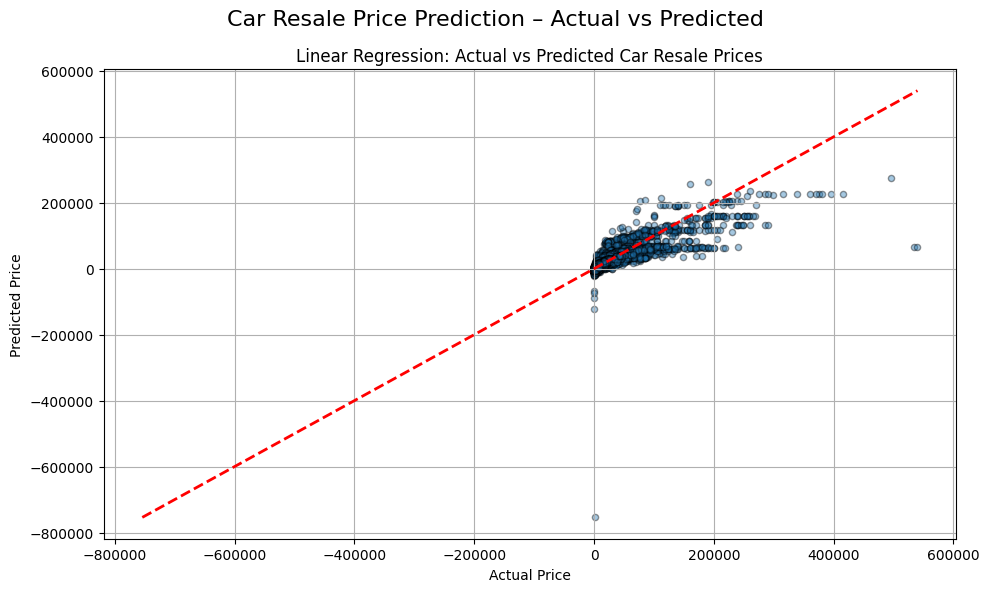

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tabulate import tabulate


#file paths for price and advertisement table
price_table = "/content/drive/MyDrive/DMML DATA/tables_V2.0/Price_table.csv"
adv_table = "/content/drive/MyDrive/DMML DATA/tables_V2.0/Adv_table.csv"

#read price table and advertisement table
price = pd.read_csv(price_table, low_memory=False)
adv = pd.read_csv(adv_table, low_memory=False)

#ensuring that both tables have been read
print(f"Price Table size: {price.head}")
print(f"Ad Table size: {adv.head}\n")

#cleaning data by removing leading spaces in column names to prevent merge errors
price.columns = price.columns.str.strip()
adv.columns = adv.columns.str.strip()

#data cleaning for numeric fields (Engin_size, Runned_miles)
def clean_miles(value):
    #mileage column has values like 12,000 so we remove commas
    if pd.isna(value):
        return np.nan
    value = str(value).lower().replace('mile', '').replace(',', '').strip()
    try:
        return float(value)
    except:
        return np.nan  #if conversion fails, return NaN

#helper function to clean Engin_size column ('2.0L')
def clean_engine_size(value):
    #removes 'L' and returns the numeric float value only
    if pd.isna(value):
        return np.nan
    value = str(value).lower().replace('l', '').strip()
    try:
        return float(value)
    except:
        return np.nan

#apply cleaning to mileage and engine size fields
adv['Runned_Miles'] = adv['Runned_Miles'].apply(clean_miles)
adv['Engin_size'] = adv['Engin_size'].apply(clean_engine_size)

#clean price column by removing currency symbols and leading spaces
adv['Price'] = adv['Price'].astype(str).str.replace(r'[\$,]', '', regex=True)
adv['Price'] = pd.to_numeric(adv['Price'], errors='coerce')


#merge tables based on Maker, Genmodel_ID, Reg_year
#proper merge ensures each ad entry receives entry price info
if 'Reg_year' in adv.columns and 'Year' in price.columns:
    right_columns = ['Maker', 'Genmodel_ID', 'Year', 'Entry_price']

    #merge advertisement table with price table based on car identity
    df = pd.merge(
        adv, price[right_columns],
        how='left',
        left_on=['Maker', 'Genmodel_ID', 'Reg_year'],
        right_on=['Maker', 'Genmodel_ID', 'Year']
    )
else:
    #fallback merge if year columns do not align properly
    df = pd.merge(adv, price, on=['Maker', 'Genmodel_ID'], how='left')

#ensuring succesfull merge of tables
print(f"Merged Data Shape: {df.shape}")

#count unique makers to give a sense of dataset
if 'Maker' in df.columns:
    print(f"Number of unique Makers: {df['Maker'].nunique()}\n")

#numerical fields used for prediction
numeric_features = [
    'Entry_price', 'Runned_Miles', 'Engin_size',
    'Seat_num', 'Door_num', 'Price'
]

#removing rows missing essential numeric values
before_rows = len(df)
df = df.dropna(subset=[col for col in numeric_features if col in df.columns])
after_rows = len(df)
skipped = before_rows - after_rows

if skipped > 0:
    print(f"Warning: Skipped {skipped} rows due to missing numeric values.\n")

# determine which feature columns are actually available
available_features = [
    f for f in ['Entry_price', 'Runned_Miles', 'Engin_size', 'Seat_num', 'Door_num']
    if f in df.columns
]

#includes selected numeric predictors
numerical_features = df[available_features]

#target variable is actual market price from advertisement
target_variable = df['Price']

#fill any leftover missing values as precaution
numerical_features = numerical_features.fillna(0)
target_variable = target_variable.fillna(0)


#test train split is based on the make of the car, lets say if Ford had 80 cars in thedata set 80% is used for training and 20% for testing.
def test_train_split(df, group_col, test_size=0.2):

    training_data = []
    testing_data = []

    min_samples_required = 1 / (1 - test_size)
    if min_samples_required <= 1:
        min_samples_required = 2

    skipped_groups = 0

    for group_name, group in df.groupby(group_col):

        if len(group) < 2:
            skipped_groups += 1
            training_data.extend(group.index)
            continue

        group_train_indices, group_test_indices = train_test_split(
            group.index,
            test_size=test_size,
            random_state=42
        )
        training_data.extend(group_train_indices)
        testing_data.extend(group_test_indices)

    if skipped_groups > 0:
        print(f"\nWarning: Skipped {skipped_groups} Maker groups (rows) that had fewer than 2 samples to split.")

    return df.loc[training_data].index, df.loc[testing_data].index

train_index, test_index = custom_group_split(df, 'Maker', test_size=0.2)

#apply the indices to the numerical features and target variable
X_train = numerical_features.loc[train_index]
X_test = numerical_features.loc[test_index]
y_train = target_variable.loc[train_index]
y_test = target_variable.loc[test_index]

# ensuring test train split
print("Train/Test Split")
print(f"Total samples: {len(df)}")
print(f"Training samples: {len(X_train)} ({(len(X_train)/len(df)):.1%})")
print(f"Testing samples: {len(X_test)} ({(len(X_test)/len(df)):.1%})\n")


#training the linear model
#create the model object and fit it on training data
print("Training Linear Regression Model...")
model = LinearRegression()
model.fit(X_train, y_train)
print("Training complete.\n")


#predict prices for unseen test set
y_pred = model.predict(X_test)

#compute accuracy metrics to understand model performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

#calculate error relative to average price to understand model quality
avg_price = y_test.mean()
error_percent = (rmse / avg_price) * 100

#display evaluation metrics calculated
print("\nModel Performance Metrics")
print(f"R-squared (R²): {r2:.4f} ({r2*100:.2f}%)")
print(f"Mean Absolute Error (MAE): {mae:,.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:,.2f}\n")
print("R² shows model fit (1.0 = perfect). RMSE shows typical prediction error.")
print(f"Average resale price in test set: {avg_price:,.2f}")
print(f"Model error (RMSE) is {error_percent:.2f}% of the average resale price.")




#Actual vs Predicted Table with Car Info
cols_to_show = ['Maker', 'Genmodel', 'Reg_year']
cols_to_show = [c for c in cols_to_show if c in df.columns]

#construct a summary table for output
results_df = pd.DataFrame({
    'Actual_Resale_Price': y_test.values,
    'Predicted_Resale_Price': np.round(y_pred, 2)
}, index=y_test.index)

#attach car details to the results table
if cols_to_show:
    results = pd.concat([df.loc[y_test.index, cols_to_show], results_df], axis=1)

print("\nActual vs Predicted Prices (Sample)")
print(tabulate(results.head(10), headers="keys", tablefmt="grid", showindex=False))



#randomly select a different vehicle each time
sample_row = df.sample(1)
sample_features = sample_row[available_features]
sample_actual = sample_row['Price'].values[0]

#predict price for the selected vehicle
predicted_price = model.predict(sample_features)[0]

#build readable car name if all identifiers exist
car_name = "Sample Vehicle"
if all(col in df.columns for col in ['Maker', 'Genmodel', 'Reg_year']):
    car_name = (
        f"{sample_row['Maker'].values[0]} "
        f"{sample_row['Genmodel'].values[0]} "
        f"({int(sample_row['Reg_year'].values[0])})"
    )

#compute single-car accuracy percentage
single_error = abs(sample_actual - predicted_price)
single_accuracy = (1 - (single_error / sample_actual)) * 100

print("\n--- SINGLE CAR PREDICTION ---")
print(f"Car: {car_name}")
print(f"Actual Resale Price: ${sample_actual:,.2f}")
print(f"Model Predicted Price: ${predicted_price:,.2f}")
print(f"Difference (Error): ${single_error:,.2f}")
print(f"Prediction Accuracy: {single_accuracy:.2f}%")

#scatter plot: Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.suptitle("Car Resale Price Prediction – Actual vs Predicted", fontsize=16)
plt.scatter(y_test, y_pred, alpha=0.4, edgecolor='k', s=20)
#prediction line (y = x)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
plt.title("Linear Regression: Actual vs Predicted Car Resale Prices")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# the two tables used to train the model are price table and advertisement table
# file paths for both tables
price_table = "/content/drive/MyDrive/DMML DATA/tables_V2.0/Price_table.csv"
adv_table = "/content/drive/MyDrive/DMML DATA/tables_V2.0/Adv_table.csv"

# reading both tables
price_data = pd.read_csv(price_table, low_memory=False)
adv_data = pd.read_csv(adv_table, low_memory=False)

#removing extra whitespaces from every string of each column (because of KeyError)
price_data.columns = price_data.columns.str.strip()
adv_data.columns = adv_data.columns.str.strip()

print("Data Loaded")

#checking if data got loaded
print(f"Price Table size: {price_data.shape}")
print(f"Ad Table size: {adv_data.shape}")

#data cleaning and preprocessing
#target Variable is resale price which is 'Price' from Adv_Table
TARGET_COLUMN = 'Price'

#Clean Engin_size in Adv_table to remove non-numeric labels like L(litre)
def clean_engine_size(size_str):
   #converts engine size string (e.g., '2.0L') to float (2.0)
    if pd.isna(size_str):
        return None
    try:
        #remove 'L'
        return float(str(size_str).replace('L', '').strip())
    except ValueError:
        return None


adv_data['Engine_size_L'] = adv_data['Engin_size'].apply(clean_engine_size)
#drop original Engin_size column
adv_data = adv_data.drop(columns=['Engin_size'])

#Clean and convert Runned_Miles and Price to numeric (removing commas)
def clean_and_convert_numeric(series):
    #convert to string, replace common non-numeric characters (like commas), then coerce to numeric
    clean_series = series.astype(str).str.replace(r'[$,]', '', regex=True).str.strip()
    return pd.to_numeric(clean_series, errors='coerce')

adv_data['Runned_Miles'] = clean_and_convert_numeric(adv_data['Runned_Miles'])
#apply cleaning to Price
adv_data['Price'] = clean_and_convert_numeric(adv_data['Price'])


#Merge Data
#merge is done on Maker, Genmodel_ID, and Year to link advertisement features to the specific year's MSRP/Entry_price
merge_cols_adv = ['Maker', 'Genmodel_ID', 'Reg_year']
merge_cols_price = ['Maker', 'Genmodel_ID', 'Year']

#rename 'Reg_year' in adv_data to 'Year' for consistent merging
adv_data = adv_data.rename(columns={'Reg_year': 'Year'})

#merging the Price_table just to get the 'Entry_price' as a feature.
merged_df = pd.merge(
    adv_data,
    #pulling 'Entry_price' to use as a feature
    price_data[['Maker', 'Genmodel_ID', 'Year', 'Entry_price']],
    on=['Maker', 'Genmodel_ID', 'Year'],
    how='left'
)

print(f"\n--- Merged Data Shape: {merged_df.shape} ---")
print(f"Number of unique Makers: {merged_df['Maker'].nunique()}")

#handle missing values and feature selection
#dropping rows with nulls
merged_df = merged_df.dropna(subset=[
    'Runned_Miles', 'Engine_size_L', 'Seat_num', 'Door_num', TARGET_COLUMN
])

#features to be used for prediction
num_features = ['Runned_Miles', 'Engine_size_L', 'Seat_num', 'Door_num', 'Adv_year', 'Entry_price']
#filling null values in 'Entry_price' with the median
merged_df['Entry_price'] = merged_df['Entry_price'].fillna(merged_df['Entry_price'].median())

categorical_features = ['Maker', 'Genmodel', 'Color', 'Bodytype', 'Gearbox', 'Fuel_type']
total_features = num_features + categorical_features

X = merged_df[total_features]
y = merged_df[TARGET_COLUMN]

#converting categorical features into numerical format using One-Hot Encoding
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)

#Test Train Split (80-20 per Maker): if there are 80 cars of Maker 'Bentley' then 0.80*80 will be used for training and 0.20*80 will be used for testing purposes.
def custom_group_split(df, group_col, test_size=0.2):

    training_data = []
    testing_data = []

    #calculate the minimum number of samples needed for a split
    #if test_size is 0.2, min samples needed is 2 (1 in train, 1 in test)
    min_samples_required = 1 / (1 - test_size)
    if min_samples_required <= 1:
        min_samples_required = 2

    skipped_groups = 0

    for group_name, group in df.groupby(group_col):

        if len(group) < 2:
            #skip this group if it's too small to be split
            skipped_groups += 1
            training_data.extend(group.index)
            continue

        #use simple train_test_split on the indices of the group
        group_train_indices, group_test_indices = train_test_split(
            group.index,
            test_size=test_size,
            random_state=42
        )
        training_data.extend(group_train_indices)
        testing_data.extend(group_test_indices)

    if skipped_groups > 0:
        print(f"\nWarning: Skipped {skipped_groups} Maker groups (rows) that had fewer than 2 samples to split.")

    return df.loc[training_data].index, df.loc[testing_data].index

#get the indices for the split
train_index, test_index = custom_group_split(merged_df, 'Maker', test_size=0.2)

#craeting the final train and test sets using the indices
X_train = X_encoded.loc[train_index]
X_test = X_encoded.loc[test_index]
y_train = y.loc[train_index]
y_test = y.loc[test_index]

#checking split distribution for verification
print(f"\n--- Train/Test Split ---")
print(f"Total samples: {len(X_encoded)}")
print(f"Training samples: {len(X_train)} ({len(X_train)/len(X_encoded):.1%})")
print(f"Testing samples: {len(X_test)} ({len(X_test)/len(X_encoded):.1%})")

#training XGBoost Model
print("\nTraining XGBoost Regressor for Resale Price")

#initialize and train the XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

print("Training complete.")

#prediction and evaluation
y_pred = xgb_model.predict(X_test)

#evaluation metrics calculations
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\nModel Evaluation (Resale Price)")
print(f"R-squared (Accuracy): {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:,.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:,.2f}")

#Output Actual vs Predicted Prices
results_df = pd.DataFrame({
    'Actual_Resale_Price': y_test,
    'Predicted_Resale_Price': y_pred.round(2)
})

#add Maker and Genmodel back for context
context_df = merged_df.loc[test_index][['Maker', 'Genmodel', 'Year']]
results_df = context_df.merge(results_df, left_index=True, right_index=True)

print("\n--- Actual vs. Predicted Resale Prices (Sample of Test Set) ---")
print(results_df.head(10).to_markdown(index=False, numalign="left", stralign="left"))

#scatter plot showing predicted values against the line of actual values
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Actual_Resale_Price', y='Predicted_Resale_Price', data=results_df, alpha=0.5, s=15)
#find the maximum value for the limits
max_price = results_df[['Actual_Resale_Price', 'Predicted_Resale_Price']].max().max()
plt.plot([0, max_price], [0, max_price], color='red', linestyle='--', label='Ideal Prediction (y=x)')
plt.title('XGBoost: Actual vs. Predicted Car Resale Prices')
plt.xlabel('Actual Resale Price')
plt.ylabel('Predicted Resale Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Data Loaded
Price Table size: (6333, 5)
Ad Table size: (268255, 15)

--- Merged Data Shape: (268255, 16) ---
Number of unique Makers: 88


--- Train/Test Split ---
Total samples: 255898
Training samples: 204693 (80.0%)
Testing samples: 51205 (20.0%)

Training XGBoost Regressor for Resale Price
Training complete.

Model Evaluation (Resale Price)
R-squared (Accuracy): 0.9422
Mean Absolute Error (MAE): 2,583.35
Root Mean Squared Error (RMSE): 4,792.05

--- Actual vs. Predicted Resale Prices (Sample of Test Set) ---
| Maker   | Genmodel   | Year   | Actual_Resale_Price   | Predicted_Resale_Price   |
|:--------|:-----------|:-------|:----------------------|:-------------------------|
| Abarth  | 595        | 2018   | 13000                 | 13145.8                  |
| Abarth  | 595C       | 2019   | 26075                 | 20144.3                  |
| Abarth  | 595        | 2014   | 10990                 | 8254.4                   |
| Abarth  | 595        | 2016   | 11500                 |

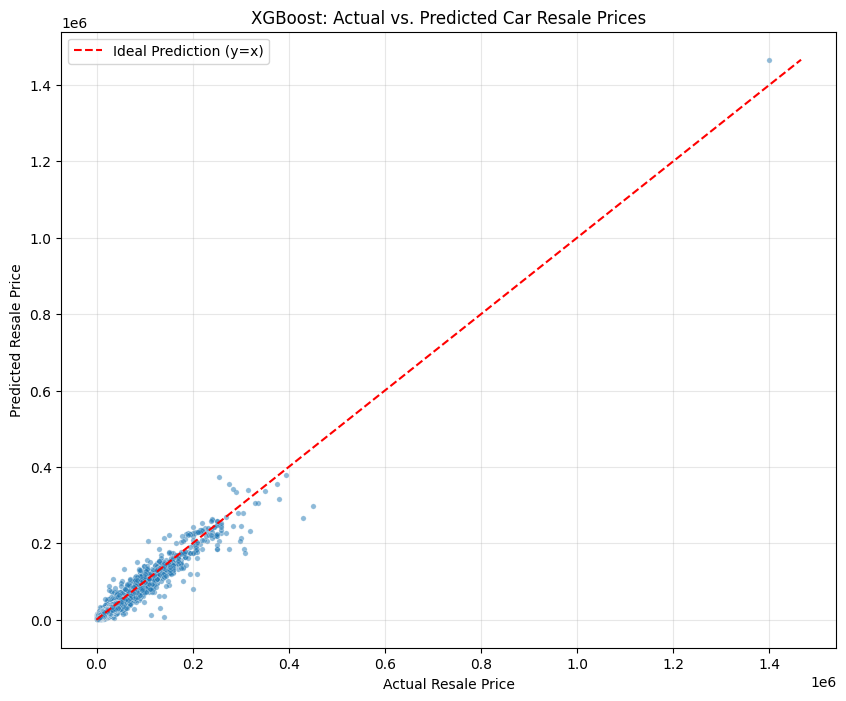

In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# the two tables used to train the model are price table and advertisement table
# file paths for both tables
price_table = "/content/drive/MyDrive/DMML DATA/tables_V2.0/Price_table.csv"
adv_table = "/content/drive/MyDrive/DMML DATA/tables_V2.0/Adv_table.csv"

# reading both tables
price_data = pd.read_csv(price_table, low_memory=False)
adv_data = pd.read_csv(adv_table, low_memory=False)

#removing extra whitespaces from every string of each column (because of KeyError)
price_data.columns = price_data.columns.str.strip()
adv_data.columns = adv_data.columns.str.strip()

print("Data Loaded")

#checking if data got loaded
print(f"Price Table size: {price_data.shape}")
print(f"Ad Table size: {adv_data.shape}")

#data cleaning and preprocessing
#target Variable is resale price which is 'Price' from Adv_Table
TARGET_COLUMN = 'Price'

#Clean Engin_size in Adv_table to remove non-numeric labels like L(litre)
def clean_engine_size(size_str):
   #converts engine size string (e.g., '2.0L') to float (2.0)
    if pd.isna(size_str):
        return None
    try:
        #remove 'L'
        return float(str(size_str).replace('L', '').strip())
    except ValueError:
        return None


adv_data['Engine_size_L'] = adv_data['Engin_size'].apply(clean_engine_size)
#drop original Engin_size column
adv_data = adv_data.drop(columns=['Engin_size'])

#Clean and convert Runned_Miles and Price to numeric (removing commas)
def clean_and_convert_numeric(series):
    #convert to string, replace common non-numeric characters (like commas), then coerce to numeric
    clean_series = series.astype(str).str.replace(r'[$,]', '', regex=True).str.strip()
    return pd.to_numeric(clean_series, errors='coerce')

adv_data['Runned_Miles'] = clean_and_convert_numeric(adv_data['Runned_Miles'])
#apply cleaning to Price
adv_data['Price'] = clean_and_convert_numeric(adv_data['Price'])


#Merge Data
#merge is done on Maker, Genmodel_ID, and Year to link advertisement features to the specific year's MSRP/Entry_price
merge_cols_adv = ['Maker', 'Genmodel_ID', 'Reg_year']
merge_cols_price = ['Maker', 'Genmodel_ID', 'Year']

#rename 'Reg_year' in adv_data to 'Year' for consistent merging
adv_data = adv_data.rename(columns={'Reg_year': 'Year'})

#merging the Price_table just to get the 'Entry_price' as a feature.
merged_df = pd.merge(
    adv_data,
    #pulling 'Entry_price' to use as a feature
    price_data[['Maker', 'Genmodel_ID', 'Year', 'Entry_price']],
    on=['Maker', 'Genmodel_ID', 'Year'],
    how='left'
)

print(f"\n--- Merged Data Shape: {merged_df.shape} ---")
print(f"Number of unique Makers: {merged_df['Maker'].nunique()}")

#handle missing values and feature selection
#dropping rows with nulls
merged_df = merged_df.dropna(subset=[
    'Runned_Miles', 'Engine_size_L', 'Seat_num', 'Door_num', TARGET_COLUMN
])

#features to be used for prediction
num_features = ['Runned_Miles', 'Engine_size_L', 'Seat_num', 'Door_num', 'Adv_year', 'Entry_price']
#filling null values in 'Entry_price' with the median
merged_df['Entry_price'] = merged_df['Entry_price'].fillna(merged_df['Entry_price'].median())

categorical_features = ['Maker', 'Genmodel', 'Color', 'Bodytype', 'Gearbox', 'Fuel_type']
total_features = num_features + categorical_features

X = merged_df[total_features]
y = merged_df[TARGET_COLUMN]

#converting categorical features into numerical format using One-Hot Encoding
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)

#Test Train Split (80-20 per Maker): if there are 80 cars of Maker 'Bentley' then 0.80*80 will be used for training and 0.20*80 will be used for testing purposes.
def custom_group_split(df, group_col, test_size=0.2):

    training_data = []
    testing_data = []

    #calculate the minimum number of samples needed for a split
    #if test_size is 0.2, min samples needed is 2 (1 in train, 1 in test)
    min_samples_required = 1 / (1 - test_size)
    if min_samples_required <= 1:
        min_samples_required = 2

    skipped_groups = 0

    for group_name, group in df.groupby(group_col):

        if len(group) < 2:
            #skip this group if it's too small to be split
            skipped_groups += 1
            training_data.extend(group.index)
            continue

        #use simple train_test_split on the indices of the group
        group_train_indices, group_test_indices = train_test_split(
            group.index,
            test_size=test_size,
            random_state=42
        )
        training_data.extend(group_train_indices)
        testing_data.extend(group_test_indices)

    if skipped_groups > 0:
        print(f"\nWarning: Skipped {skipped_groups} Maker groups (rows) that had fewer than 2 samples to split.")

    return df.loc[training_data].index, df.loc[testing_data].index

#get the indices for the split
train_index, test_index = custom_group_split(merged_df, 'Maker', test_size=0.2)

#craeting the final train and test sets using the indices
X_train = X_encoded.loc[train_index]
X_test = X_encoded.loc[test_index]
y_train = y.loc[train_index]
y_test = y.loc[test_index]

#checking split distribution for verification
print(f"\n--- Train/Test Split ---")
print(f"Total samples: {len(X_encoded)}")
print(f"Training samples: {len(X_train)} ({len(X_train)/len(X_encoded):.1%})")
print(f"Testing samples: {len(X_test)} ({len(X_test)/len(X_encoded):.1%})")

#training XGBoost Model
print("\nTraining XGBoost Regressor for Resale Price")

#initialize and train the XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

print("Training complete.")

#prediction and evaluation
y_pred = xgb_model.predict(X_test)

#evaluation metrics calculations
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\nModel Evaluation (Resale Price)")
print(f"R-squared (Accuracy): {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:,.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:,.2f}")

#Output Actual vs Predicted Prices
results_df = pd.DataFrame({
    'Actual_Resale_Price': y_test,
    'Predicted_Resale_Price': y_pred.round(2)
})

#add Maker and Genmodel back for context
context_df = merged_df.loc[test_index][['Maker', 'Genmodel', 'Year']]
results_df = context_df.merge(results_df, left_index=True, right_index=True)

print("\n--- Actual vs. Predicted Resale Prices (Sample of Test Set) ---")
print(results_df.head(10).to_markdown(index=False, numalign="left", stralign="left"))

#scatter plot showing predicted values against the line of actual values
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Actual_Resale_Price', y='Predicted_Resale_Price', data=results_df, alpha=0.5, s=15)
#find the maximum value for the limits
max_price = results_df[['Actual_Resale_Price', 'Predicted_Resale_Price']].max().max()
plt.plot([0, max_price], [0, max_price], color='red', linestyle='--', label='Ideal Prediction (y=x)')
plt.title('XGBoost: Actual vs. Predicted Car Resale Prices')
plt.xlabel('Actual Resale Price')
plt.ylabel('Predicted Resale Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [5]:
# rq2_image_classification.py
# RQ2: Image classification for body type & manufacturer using DVM-CAR resized images
# Approaches:
#   1) Transfer learning with a pre-trained CNN (single task: bodytype OR manufacturer, softmax outputs)
#   2) Multi-task with two softmax heads (bodytype AND manufacturer, softmax outputs)
#
# USAGE EXAMPLES:
#   python rq2_image_classification.py --approach single --single_target bodytype
#   python rq2_image_classification.py --approach single --single_target manufacturer
#   python rq2_image_classification.py --approach multitask
#
# ---- SETUP ----
# 1) pip install -U torch torchvision pandas numpy scikit-learn Pillow matplotlib seaborn
# 2) Edit the Config paths below to your CSVs and image root
# 3) We assume: using the full resized DVM (not the quality-checked subset).
#    We do NOT filter by quality; we keep all angles (Predicted_viewpoint) and avoid leakage by Adv_ID grouping.

from pathlib import Path
import json
import random
import argparse
from dataclasses import dataclass, asdict
from typing import List, Dict

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from PIL import Image

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

import torchvision.transforms as T
from torchvision.models import resnet50, ResNet50_Weights


# =========================
# CONFIG: EDIT THESE PATHS
# =========================
@dataclass
class Config:
    # Paths
    dataset_root: str = "/path/to/DVM_images_root"     # folder with 300x300 JPGs; image paths are relative to this
    ad_csv: str = "/path/to/Ad_table.csv"
    image_csv: str = "/path/to/Image_table.csv"
    basic_csv: str = "/path/to/Basic_table.csv"

    # Column names
    col_adv_id: str = "Adv_ID"
    col_genmodel_id: str = "Genmodel_ID"
    col_image_name: str = "Image_name"
    col_pred_view: str = "Predicted_viewpoint"
    col_quality: str = "quality_check"
    col_bodytype: str = "Bodytype"                     # label for task 1
    col_automaker_basic: str = "Automaker"             # label for task 2 (via Basic table)

    # Training
    seed: int = 42
    num_workers: int = 4
    batch_size: int = 64
    epochs: int = 10
    lr: float = 1e-3
    weight_decay: float = 1e-4
    freeze_backbone: bool = True                       # classic transfer learning; set False to fine-tune

    # Split (grouped by Adv_ID to avoid leakage)
    train_size: float = 0.8
    val_size_of_rest: float = 0.5                      # 50% of remainder to val; rest to test

    # Images
    image_size: int = 224
    use_mixed_precision: bool = True

    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    out_dir: str = "./rq2_outputs"
    approach: str = "single"                           # "single" or "multitask"
    single_task_target: str = "bodytype"               # used when approach=="single"


def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


# =========================
# Data loading & joins
# =========================
def load_and_join(cfg: Config) -> pd.DataFrame:
    """Join Image↔Ad↔Basic to get image_path, Bodytype, Automaker, Adv_ID, Predicted_viewpoint."""
    ad = pd.read_csv(cfg.ad_csv)
    img = pd.read_csv(cfg.image_csv)
    basic = pd.read_csv(cfg.basic_csv)

    ad = ad[[cfg.col_adv_id, cfg.col_genmodel_id, cfg.col_bodytype]]
    img = img[[cfg.col_adv_id, cfg.col_genmodel_id, cfg.col_image_name, cfg.col_pred_view, cfg.col_quality]]
    basic = basic[[cfg.col_genmodel_id, cfg.col_automaker_basic]].drop_duplicates(cfg.col_genmodel_id)

    df = img.merge(ad, on=[cfg.col_adv_id, cfg.col_genmodel_id], how="inner")
    df = df.merge(basic, on=cfg.col_genmodel_id, how="left")

    # build full path to the image on disk
    root = Path(cfg.dataset_root)
    df["image_path"] = df[cfg.col_image_name].astype(str).apply(lambda p: str(root / p))

    # drop rows missing labels or path
    df = df.dropna(subset=[cfg.col_bodytype, cfg.col_automaker_basic, "image_path"]).reset_index(drop=True)
    return df


# =========================
# Dataset
# =========================
class DVMImageDataset(Dataset):
    def __init__(self, df: pd.DataFrame, body_enc: LabelEncoder, maker_enc: LabelEncoder,
                 cfg: Config, split: str = "train"):
        self.df = df.reset_index(drop=True)
        self.cfg = cfg
        self.body_enc = body_enc
        self.maker_enc = maker_enc
        self.split = split

        if split == "train":
            self.transform = T.Compose([
                T.Resize(int(cfg.image_size * 1.15)),
                T.RandomResizedCrop(cfg.image_size, scale=(0.8, 1.0)),
                T.RandomHorizontalFlip(),
                T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                T.ToTensor(),
                T.Normalize(mean=ResNet50_Weights.IMAGENET1K_V2.meta["mean"],
                            std=ResNet50_Weights.IMAGENET1K_V2.meta["std"]),
            ])
        else:
            self.transform = T.Compose([
                T.Resize(cfg.image_size + 32),
                T.CenterCrop(cfg.image_size),
                T.ToTensor(),
                T.Normalize(mean=ResNet50_Weights.IMAGENET1K_V2.meta["mean"],
                            std=ResNet50_Weights.IMAGENET1K_V2.meta["std"]),
            ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["image_path"]).convert("RGB")
        x = self.transform(img)

        y_body = int(self.body_enc.transform([row[self.cfg.col_bodytype]])[0])
        y_maker = int(self.maker_enc.transform([row[self.cfg.col_automaker_basic]])[0])

        adv_id = row[self.cfg.col_adv_id]
        viewpoint = row[self.cfg.col_pred_view]
        return x, y_body, y_maker, adv_id, viewpoint


# =========================
# Models
# =========================
class SingleHeadResNet(nn.Module):
    """Single-task transfer learning: ResNet50 + Linear head -> logits (softmax in CE)."""
    def __init__(self, num_classes: int, freeze_backbone: bool = True):
        super().__init__()
        self.backbone = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        if freeze_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False
        in_feats = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_feats, num_classes)  # logits for CrossEntropy (softmax applied internally)

    def forward(self, x):
        return self.backbone(x)


class MultiHeadResNet(nn.Module):
    """Multi-task: shared ResNet50 backbone, two heads (bodytype & manufacturer), each softmaxed by CE."""
    def __init__(self, num_bodytypes: int, num_makers: int, freeze_backbone: bool = True):
        super().__init__()
        self.backbone = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        if freeze_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False
        in_feats = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        self.head_body = nn.Linear(in_feats, num_bodytypes)  # logits
        self.head_maker = nn.Linear(in_feats, num_makers)    # logits

    def forward(self, x):
        feats = self.backbone(x)
        return self.head_body(feats), self.head_maker(feats)


# =========================
# Metrics & helpers
# =========================
def compute_metrics(y_true, y_pred) -> Dict[str, float]:
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1_macro": f1_score(y_true, y_pred, average="macro"),
        "f1_weighted": f1_score(y_true, y_pred, average="weighted"),
    }

def plot_confmat(cm: np.ndarray, classes: List[str], title: str, out_path: Path):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=False, fmt="d", xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.tight_layout()
    out_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(out_path)
    plt.close()

def save_json(obj, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)


# =========================
# Train/Eval (single-task)
# =========================
def train_single(cfg: Config, df_train, df_val, df_test, body_enc, maker_enc):
    target = cfg.single_task_target
    classes = list(body_enc.classes_) if target == "bodytype" else list(maker_enc.classes_)
    num_classes = len(classes)

    model = SingleHeadResNet(num_classes=num_classes, freeze_backbone=cfg.freeze_backbone).to(cfg.device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    scaler = torch.cuda.amp.GradScaler(enabled=cfg.use_mixed_precision)

    def mk_loader(df, split):
        ds = DVMImageDataset(df, body_enc, maker_enc, cfg, split=split)
        return DataLoader(ds, batch_size=cfg.batch_size, shuffle=(split=="train"),
                          num_workers=cfg.num_workers, pin_memory=True)

    train_loader = mk_loader(df_train, "train")
    val_loader   = mk_loader(df_val,   "val")
    test_loader  = mk_loader(df_test,  "test")

    history = {"train_loss": [], "val_loss": [], "val_acc": [], "val_f1_macro": []}

    for epoch in range(cfg.epochs):
        model.train()
        total_loss = 0.0
        for xb, yb, ym, _, _ in train_loader:
            xb = xb.to(cfg.device, non_blocking=True)
            y  = (yb if target == "bodytype" else ym).to(cfg.device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=cfg.use_mixed_precision):
                logits = model(xb)
                loss = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item() * xb.size(0)

        # validate
        model.eval()
        val_loss, y_true, y_pred = 0.0, [], []
        with torch.no_grad():
            for xb, yb, ym, _, _ in val_loader:
                xb = xb.to(cfg.device, non_blocking=True)
                y  = (yb if target == "bodytype" else ym).to(cfg.device, non_blocking=True)
                with torch.cuda.amp.autocast(enabled=cfg.use_mixed_precision):
                    logits = model(xb)
                    loss = criterion(logits, y)
                val_loss += loss.item() * xb.size(0)
                pred = torch.argmax(logits, dim=1).cpu().numpy().tolist()
                y_true += y.cpu().numpy().tolist()
                y_pred += pred

        metrics = compute_metrics(y_true, y_pred)
        history["train_loss"].append(total_loss / len(train_loader.dataset))
        history["val_loss"].append(val_loss / len(val_loader.dataset))
        history["val_acc"].append(metrics["accuracy"])
        history["val_f1_macro"].append(metrics["f1_macro"])
        print(f"[{epoch+1}/{cfg.epochs}] train_loss={history['train_loss'][-1]:.4f} "
              f"val_loss={history['val_loss'][-1]:.4f} val_acc={metrics['accuracy']:.4f} "
              f"val_f1_macro={metrics['f1_macro']:.4f}")

    # test
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb, ym, _, _ in test_loader:
            xb = xb.to(cfg.device, non_blocking=True)
            y  = (yb if target == "bodytype" else ym).to(cfg.device, non_blocking=True)
            logits = model(xb)
            y_true += y.cpu().numpy().tolist()
            y_pred += torch.argmax(logits, dim=1).cpu().numpy().tolist()

    test_metrics = compute_metrics(y_true, y_pred)
    print("TEST:", test_metrics)

    out_dir = Path(cfg.out_dir) / f"single_{target}"
    out_dir.mkdir(parents=True, exist_ok=True)

    # confusion matrix & report
    cm = confusion_matrix(y_true, y_pred)
    plot_confmat(cm, classes, f"Confusion Matrix ({target})", out_dir / "confusion_matrix.png")
    report = classification_report(y_true, y_pred, target_names=classes, digits=3)
    (out_dir / "classification_report.txt").write_text(report)

    save_json({"history": history, "test_metrics": test_metrics, "config": asdict(cfg)}, out_dir / "results.json")
    torch.save(model.state_dict(), out_dir / "model.pt")


# =========================
# Train/Eval (multi-task)
# =========================
def train_multitask(cfg: Config, df_train, df_val, df_test, body_enc, maker_enc):
    num_body = len(body_enc.classes_)
    num_maker = len(maker_enc.classes_)
    model = MultiHeadResNet(num_body, num_maker, freeze_backbone=cfg.freeze_backbone).to(cfg.device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    scaler = torch.cuda.amp.GradScaler(enabled=cfg.use_mixed_precision)

    def mk_loader(df, split):
        ds = DVMImageDataset(df, body_enc, maker_enc, cfg, split=split)
        return DataLoader(ds, batch_size=cfg.batch_size, shuffle=(split=="train"),
                          num_workers=cfg.num_workers, pin_memory=True)

    train_loader = mk_loader(df_train, "train")
    val_loader   = mk_loader(df_val,   "val")
    test_loader  = mk_loader(df_test,  "test")

    history = {"train_loss": [], "val_loss": [], "val_acc_body": [], "val_f1_body": [],
               "val_acc_maker": [], "val_f1_maker": []}

    for epoch in range(cfg.epochs):
        model.train()
        total_loss = 0.0
        for xb, yb, ym, _, _ in train_loader:
            xb, yb, ym = xb.to(cfg.device, non_blocking=True), yb.to(cfg.device, non_blocking=True), ym.to(cfg.device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=cfg.use_mixed_precision):
                logits_b, logits_m = model(xb)
                loss = criterion(logits_b, yb) + criterion(logits_m, ym)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item() * xb.size(0)

        # validate
        model.eval()
        val_loss, yb_true, yb_pred, ym_true, ym_pred = 0.0, [], [], [], []
        with torch.no_grad():
            for xb, yb, ym, _, _ in val_loader:
                xb, yb, ym = xb.to(cfg.device, non_blocking=True), yb.to(cfg.device, non_blocking=True), ym.to(cfg.device, non_blocking=True)
                with torch.cuda.amp.autocast(enabled=cfg.use_mixed_precision):
                    logits_b, logits_m = model(xb)
                    loss = criterion(logits_b, yb) + criterion(logits_m, ym)
                val_loss += loss.item() * xb.size(0)
                yb_true += yb.cpu().numpy().tolist()
                ym_true += ym.cpu().numpy().tolist()
                yb_pred += torch.argmax(logits_b, dim=1).cpu().numpy().tolist()
                ym_pred += torch.argmax(logits_m, dim=1).cpu().numpy().tolist()

        mb = compute_metrics(yb_true, yb_pred)
        mm = compute_metrics(ym_true, ym_pred)
        history["train_loss"].append(total_loss / len(train_loader.dataset))
        history["val_loss"].append(val_loss / len(val_loader.dataset))
        history["val_acc_body"].append(mb["accuracy"]); history["val_f1_body"].append(mb["f1_macro"])
        history["val_acc_maker"].append(mm["accuracy"]); history["val_f1_maker"].append(mm["f1_macro"])
        print(f"[{epoch+1}/{cfg.epochs}] train_loss={history['train_loss'][-1]:.4f} "
              f"val_loss={history['val_loss'][-1]:.4f} "
              f"body_acc={mb['accuracy']:.4f} body_f1={mb['f1_macro']:.4f} "
              f"maker_acc={mm['accuracy']:.4f} maker_f1={mm['f1_macro']:.4f}")

    # test
    model.eval()
    yb_true, yb_pred, ym_true, ym_pred = [], [], [], []
    with torch.no_grad():
        for xb, yb, ym, _, _ in test_loader:
            xb, yb, ym = xb.to(cfg.device, non_blocking=True), yb.to(cfg.device, non_blocking=True), ym.to(cfg.device, non_blocking=True)
            logits_b, logits_m = model(xb)
            yb_pred += torch.argmax(logits_b, dim=1).cpu().numpy().tolist()
            ym_pred += torch.argmax(logits_m, dim=1).cpu().numpy().tolist()
            yb_true += yb.cpu().numpy().tolist()
            ym_true += ym.cpu().numpy().tolist()

    out_dir = Path(cfg.out_dir) / "multitask"
    out_dir.mkdir(parents=True, exist_ok=True)

    mb = compute_metrics(yb_true, yb_pred)
    mm = compute_metrics(ym_true, ym_pred)
    print("TEST bodytype:", mb)
    print("TEST manufacturer:", mm)

    classes_body = list(body_enc.classes_)
    classes_maker = list(maker_enc.classes_)
    cm_b = confusion_matrix(yb_true, yb_pred)
    cm_m = confusion_matrix(ym_true, ym_pred)
    plot_confmat(cm_b, classes_body, "Confusion Matrix (Bodytype)", out_dir / "confmat_bodytype.png")
    plot_confmat(cm_m, classes_maker, "Confusion Matrix (Manufacturer)", out_dir / "confmat_maker.png")

    (out_dir / "classification_report_bodytype.txt").write_text(
        classification_report(yb_true, yb_pred, target_names=classes_body, digits=3)
    )
    (out_dir / "classification_report_maker.txt").write_text(
        classification_report(ym_true, ym_pred, target_names=classes_maker, digits=3)
    )

    save_json({"history": history, "test_metrics_bodytype": mb, "test_metrics_manufacturer": mm,
               "config": asdict(cfg)}, out_dir / "results.json")
    torch.save(model.state_dict(), out_dir / "model.pt")


# =========================
# Grouped split (leak-safe)
# =========================
def group_train_val_test_split(df: pd.DataFrame, group_col: str, train_size: float, val_size_of_rest: float, seed: int):
    """Keep all images from the same advert (Adv_ID) in the same split."""
    groups = df[group_col].values
    gss = GroupShuffleSplit(n_splits=1, train_size=train_size, random_state=seed)
    train_idx, rest_idx = next(gss.split(df, groups=groups))
    df_train = df.iloc[train_idx].copy()
    df_rest = df.iloc[rest_idx].copy()

    groups_rest = df_rest[group_col].values
    gss2 = GroupShuffleSplit(n_splits=1, train_size=val_size_of_rest, random_state=seed+1)
    val_idx, test_idx = next(gss2.split(df_rest, groups=groups_rest))
    df_val = df_rest.iloc[val_idx].copy()
    df_test = df_rest.iloc[test_idx].copy()
    return df_train.reset_index(drop=True), df_val.reset_index(drop=True), df_test.reset_index(drop=True)


# =========================
# Main
# =========================
def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--approach", choices=["single", "multitask"], default="single")
    parser.add_argument("--single_target", choices=["bodytype", "manufacturer"], default="bodytype")
    parser.add_argument("--config_json", type=str, default=None, help="optional JSON to override Config fields")
    args = parser.parse_args()

    cfg = Config()
    if args.config_json:
        with open(args.config_json) as f:
            override = json.load(f)
        for k, v in override.items():
            setattr(cfg, k, v)
    cfg.approach = args.approach
    cfg.single_task_target = args.single_target

    set_seed(cfg.seed)
    Path(cfg.out_dir).mkdir(parents=True, exist_ok=True)

    print("Loading & joining CSVs…")
    df = load_and_join(cfg)
    print(f"Rows after join: {len(df)}")

    # Encode labels
    body_enc = LabelEncoder().fit(df[cfg.col_bodytype])
    maker_enc = LabelEncoder().fit(df[cfg.col_automaker_basic])

    # Save classes
    lab_dir = Path(cfg.out_dir) / "labels"
    lab_dir.mkdir(parents=True, exist_ok=True)
    (lab_dir / "classes.json").write_text(json.dumps({
        "bodytype_classes": list(body_enc.classes_),
        "manufacturer_classes": list(maker_enc.classes_)
    }, indent=2))

    # Grouped split by Adv_ID
    print("Grouped split by Adv_ID (leak-safe)…")
    df_train, df_val, df_test = group_train_val_test_split(
        df, cfg.col_adv_id, cfg.train_size, cfg.val_size_of_rest, cfg.seed
    )
    print(f"Train: {len(df_train)} | Val: {len(df_val)} | Test: {len(df_test)}")

    # Train
    if cfg.approach == "single":
        print(f"Training SINGLE-TASK model ({cfg.single_task_target})")
        train_single(cfg, df_train, df_val, df_test, body_enc, maker_enc)
    else:
        print("Training MULTI-TASK model (bodytype + manufacturer)")
        train_multitask(cfg, df_train, df_val, df_test, body_enc, maker_enc)


if __name__ == "__main__":
    main()


usage: colab_kernel_launcher.py [-h] [--approach {single,multitask}]
                                [--single_target {bodytype,manufacturer}]
                                [--config_json CONFIG_JSON]
colab_kernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-54a2dce4-a92c-4fd7-a861-69671dea560e.json


SystemExit: 2

/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# **Random Forest - Vir**
Applying Random Forest Decision trees on tabular data of adv_table and price_table to predict resale price of given car.

Data Loaded
Price Table size: (6333, 5)
Ad Table size: (268255, 15)

--- Merged Data Shape: (268255, 16) ---
Number of unique Makers: 88


--- Train/Test Split ---
Total samples: 255898
Training samples: 204693 (80.0%)
Testing samples: 51205 (20.0%)
Model training complete.
----- Model Performance -----
MAE  : 1474.4967487880435
RMSE : 3683.927879737626
R²   : 0.9658592117262046 ( 97.0 %)

--- Actual vs. Predicted Resale Prices (Sample of Test Set) ---
| Maker   | Genmodel   | Year   | Actual_Resale_Price   | Predicted_Resale_Price   |
|:--------|:-----------|:-------|:----------------------|:-------------------------|
| Abarth  | 595        | 2018   | 13000                 | 13395.1                  |
| Abarth  | 595C       | 2019   | 26075                 | 21068.3                  |
| Abarth  | 595        | 2014   | 10990                 | 10280.1                  |
| Abarth  | 595        | 2016   | 11500                 | 11492.1                  |
| Abarth  | 595        | 2018   |

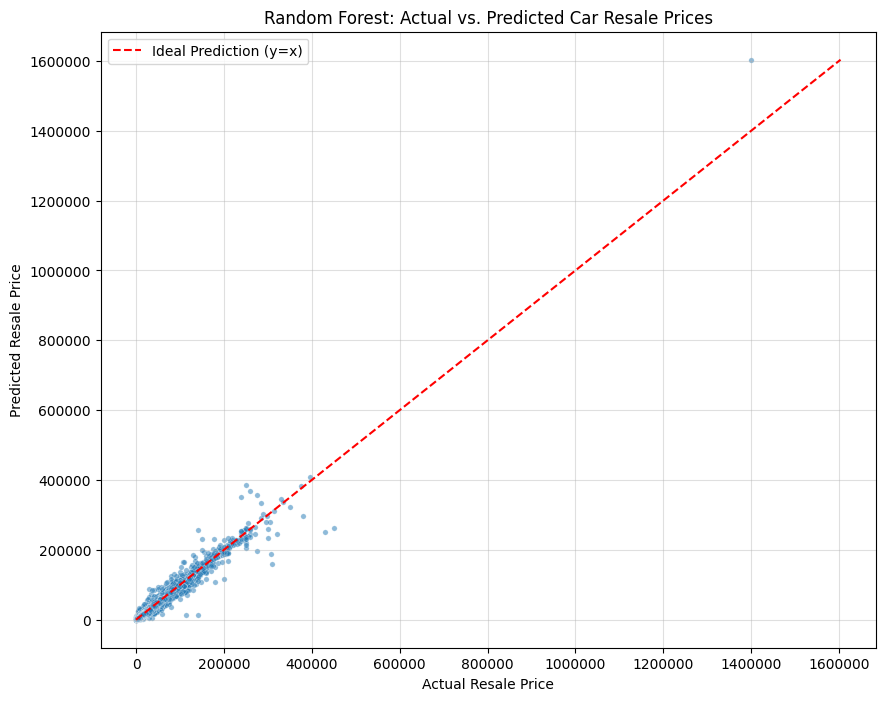

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# the two tables used to train the model are price table and advertisement table
# file paths for both tables
price_table = "/content/drive/MyDrive/DMML DATA/tables_V2.0/Price_table.csv"
adv_table = "/content/drive/MyDrive/DMML DATA/tables_V2.0/Adv_table.csv"

# reading both tables
price_data = pd.read_csv(price_table, low_memory=False)
adv_data = pd.read_csv(adv_table, low_memory=False)

# removing extra whitespaces from every string of each column (because of KeyError)
price_data.columns = price_data.columns.str.strip()
adv_data.columns = adv_data.columns.str.strip()

print("Data Loaded")

#checking if data got loaded
print(f"Price Table size: {price_data.shape}")
print(f"Ad Table size: {adv_data.shape}")

#data Cleaning and Preprocessing
# Target Variable is resale price which is 'Price' from Adv_Table
TARGET_COLUMN = 'Price'

#Clean Engin_size in Adv_table to remove non-numeric labels like L(litre)
def clean_engine_size(size_str):
   # """Converts engine size string (e.g., '2.0L') to float (2.0)."""
    if pd.isna(size_str):
        return None
    try:
        # Remove 'L'
        return float(str(size_str).replace('L', '').strip())
    except ValueError:
        return None


adv_data['Engine_size_L'] = adv_data['Engin_size'].apply(clean_engine_size)
#drop original Engin_size column
adv_data = adv_data.drop(columns=['Engin_size'])

#Clean and convert Runned_Miles and Price to numeric (removing commas)
def clean_and_convert_numeric(series):
    #"""Removes commas and attempts to convert a series to numeric, replacing errors with NaN."""
    # Convert to string, replace common non-numeric characters (like commas), then coerce to numeric
    clean_series = series.astype(str).str.replace(r'[$,]', '', regex=True).str.strip()
    return pd.to_numeric(clean_series, errors='coerce')

adv_data['Runned_Miles'] = clean_and_convert_numeric(adv_data['Runned_Miles'])
# Apply cleaning to 'Price', which is now the TARGET
adv_data['Price'] = clean_and_convert_numeric(adv_data['Price'])


#Merge Data
#merge is done on Maker, Genmodel_ID, and Year to link advertisement features to the specific year's MSRP/Entry_price
merge_cols_adv = ['Maker', 'Genmodel_ID', 'Reg_year']
merge_cols_price = ['Maker', 'Genmodel_ID', 'Year']

#rename 'Reg_year' in adv_data to 'Year' for consistent merging
adv_data = adv_data.rename(columns={'Reg_year': 'Year'})

#merging the Price_table just to get the 'Entry_price' as a feature.
merged_df = pd.merge(
    adv_data,
    # Pulling 'Entry_price' to use as a feature
    price_data[['Maker', 'Genmodel_ID', 'Year', 'Entry_price']],
    on=['Maker', 'Genmodel_ID', 'Year'],
    how='left'
)

print(f"\n--- Merged Data Shape: {merged_df.shape} ---")
print(f"Number of unique Makers: {merged_df['Maker'].nunique()}")

#Handle Missing Values and Feature selection
# Dropping rows with nulls
merged_df = merged_df.dropna(subset=[
    'Runned_Miles', 'Engine_size_L', 'Seat_num', 'Door_num', TARGET_COLUMN
])

#Features to be used for prediction
num_features = ['Runned_Miles', 'Engine_size_L', 'Seat_num', 'Door_num', 'Adv_year', 'Entry_price']
#filling null values in 'Entry_price' with the median
merged_df['Entry_price'] = merged_df['Entry_price'].fillna(merged_df['Entry_price'].median())

categorical_features = ['Maker', 'Genmodel', 'Color', 'Bodytype', 'Gearbox', 'Fuel_type']
total_features = num_features + categorical_features

X = merged_df[total_features]
y = merged_df[TARGET_COLUMN]

# Convert categorical features into numerical format using One-Hot Encoding
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)

#Test Train Split (80-20 per Maker): if there are 80 cars of Maker 'Bentley' then 0.80*80 will be used for training and 0.20*80 will be used for testing purposes.
def custom_group_split(df, group_col, test_size=0.2):

    training_data = []
    testing_data = []

    # Calculate the minimum number of samples needed for a split
    # If test_size is 0.2, min samples needed is 2 (1 in train, 1 in test)
    min_samples_required = 1 / (1 - test_size)
    if min_samples_required <= 1:
        min_samples_required = 2

    skipped_groups = 0

    for group_name, group in df.groupby(group_col):

        if len(group) < 2:
            # Skip this group if it's too small to be split into non-empty train/test sets
            skipped_groups += 1
            training_data.extend(group.index)
            continue

        # Use simple train_test_split on the indices of the group
        group_train_indices, group_test_indices = train_test_split(
            group.index,
            test_size=test_size,
            random_state=42
        )
        training_data.extend(group_train_indices)
        testing_data.extend(group_test_indices)

    if skipped_groups > 0:
        print(f"\nWarning: Skipped {skipped_groups} Maker groups (rows) that had fewer than 2 samples to split.")

    return df.loc[training_data].index, df.loc[testing_data].index

# Get the indices for the custom split
train_index, test_index = custom_group_split(merged_df, 'Maker', test_size=0.2)

# Create the final train and test sets using the indices
X_train = X_encoded.loc[train_index]
X_test = X_encoded.loc[test_index]
y_train = y.loc[train_index]
y_test = y.loc[test_index]

# Check split distribution for verification)
print(f"\n--- Train/Test Split ---")
print(f"Total samples: {len(X_encoded)}")
print(f"Training samples: {len(X_train)} ({len(X_train)/len(X_encoded):.1%})")
print(f"Testing samples: {len(X_test)} ({len(X_test)/len(X_encoded):.1%})")


model = RandomForestRegressor(
    estimators=300,
    depth=None,
    random_state=42,
    jobs=-1
)

model.fit(X_train, y_train)
print("Model training complete.")

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("----- Model Performance -----")
print("MAE  :", mae)
print("RMSE :", rmse)
print("R²   :", r2, "(",np.round(r2*100),"%)")

#Output Actual vs Predicted Prices
results_df = pd.DataFrame({
    'Actual_Resale_Price': y_test,
    'Predicted_Resale_Price': y_pred.round(2)
})

# Add Maker and Genmodel back for context
context_df = merged_df.loc[test_index][['Maker', 'Genmodel', 'Year']]
results_df = context_df.merge(results_df, left_index=True, right_index=True)

print("\n--- Actual vs. Predicted Resale Prices (Sample of Test Set) ---")
print(results_df.head(10).to_markdown(index=False, numalign="left", stralign="left"))

plot_df = pd.DataFrame({
    'Actual_Price': y_test,
    'Predicted_Price': y_pred
})

plt.figure(figsize=(10, 8))
# Use Seaborn for the scatter plot
sns.scatterplot(x='Actual_Price', y='Predicted_Price', data=plot_df, alpha=0.5, s=15)

# Calculate the limits for the perfect prediction line
max_price = plot_df[['Actual_Price', 'Predicted_Price']].max().max()

# Plot the ideal line (y=x)
plt.plot([0, max_price], [0, max_price], color='red', linestyle='--', label='Ideal Prediction (y=x)')

plt.title('Random Forest: Actual vs. Predicted Car Resale Prices')
plt.xlabel('Actual Resale Price')
plt.ylabel('Predicted Resale Price')
plt.legend()
plt.grid(True, alpha=0.4)
plt.ticklabel_format(style='plain', axis='both') # Use standard numbering instead of scientific
plt.show()
